In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import chardet
import re
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", message="The structure of `inputs` doesn't match the expected structure")
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Concatenate, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.optimizers import Adam

In [2]:
df = pd.read_csv('data_output/charting_clean.csv', low_memory=False)

In [3]:
df.head()

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,2nd_test,rallyCountVerification,Player_svr,Player_ret,1st_player_svr,1st_player_ret,2nd_player_svr,2nd_player_ret,1st_final,2nd_final
0,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,1,0,0,0.0,0.0,0-0,1 (1),1,0,...,NaN,1,Novak Djokovic,Ben Shelton,6,f2n#,NaN,NaN,6 f2n#,NaN
1,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0,1 (2),1,0,...,6 b19 f1 b2 s1 f3 f2 j2 *,8,Novak Djokovic,Ben Shelton,4n,NaN,6 f1 s1 f2,b19 b2 f3 j2*,4n,6 b19 f1 b2 s1 f3 f2 j2*
2,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,3,0,0,0.0,0.0,15-15,1 (3),1,0,...,4 b28 f2 o1 *,4,Novak Djokovic,Ben Shelton,4d,NaN,4 f2,b28 o1*,4d,4 b28 f2 o1*
3,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,4,0,0,0.0,0.0,15-30,1 (4),1,0,...,NaN,3,Novak Djokovic,Ben Shelton,6 f3*,s28,NaN,NaN,6 s28 f3*,NaN
4,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,5,0,0,0.0,0.0,30-30,1 (5),1,0,...,NaN,3,Novak Djokovic,Ben Shelton,4 b3*,b37,NaN,NaN,4 b37 b3*,NaN


# Modelo de predicción de final de punto
El objetivo de este modelo es predecir el final de un punto en un partido de tenis, es decir, si el punto terminará con un golpe ganador, un error forzado o un error no forzado.

In [4]:
# Select relevant columns
point_winning_data = df[['1stIn', '2ndIn', '1st_final', '2nd_final', 'Pt', 'Set1', 'Set2', 'Gm1', 'Gm2', 'TbSet', 'TB?', 'TBpt', 'Svr', 'Ret', 'isAce', 'isUnret', 'isRallyWinner', 'isForced', 'isUnforced', 'isDouble', 'PtWinner', 'isSvrWinner', 'rallyCount']]

# Replace values in '1st_final' with '2nd_final' if '1stIn' == 0
point_winning_data['1st_final'] = np.where(point_winning_data['1stIn'] == 0, point_winning_data['2nd_final'], point_winning_data['1st_final'])

# Drop rows where '2ndIn' is 0
point_winning_data = point_winning_data[point_winning_data['2ndIn'] != 0]

# Display the first few rows of the DataFrame
point_winning_data.head()

,1stIn,2ndIn,1st_final,2nd_final,Pt,Set1,Set2,Gm1,Gm2,TbSet,...,Ret,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
0,1,NaN,6 f2n#,NaN,1,0,0,0.0,0.0,1,...,2,False,False,False,True,False,False,1,1,1
1,0,1.0,6 b19 f1 b2 s1 f3 f2 j2*,6 b19 f1 b2 s1 f3 f2 j2*,2,0,0,0.0,0.0,1,...,2,False,False,True,False,False,False,2,0,8
2,0,1.0,4 b28 f2 o1*,4 b28 f2 o1*,3,0,0,0.0,0.0,1,...,2,False,False,True,False,False,False,2,0,4
3,1,NaN,6 s28 f3*,NaN,4,0,0,0.0,0.0,1,...,2,False,False,True,False,False,False,1,1,3
4,1,NaN,4 b37 b3*,NaN,5,0,0,0.0,0.0,1,...,2,False,False,True,False,False,False,1,1,3


In [5]:
#drop na if na in 1st_final
point_winning_data = point_winning_data.dropna(subset=['1st_final'])

In [6]:
#point_winning_data.to_csv('data_output/full_sequence.csv', index=False)

In [7]:
point_winning_data = point_winning_data.sample(frac=0.5, random_state=42) # 50% de los datos

# Preprocesamiento de datos

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(point_winning_data['1st_final'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# Convertir las secuencias en listas de tokens
tokenized_sequences = []
for seq in point_winning_data['1st_final']:
    tokens = seq.split()
    tokenized_sequence = tokenizer.texts_to_sequences([tokens])
    tokenized_sequence = [item for sublist in tokenized_sequence for item in sublist]
    tokenized_sequences.append(tokenized_sequence)

# Rellenar secuencias para que todas tengan la misma longitud
max_sequence_length = 10  # Máximo de 5 golpes para unificar el largo de las secuencias
X_seq = pad_sequences(tokenized_sequences, maxlen=max_sequence_length, padding='post')


In [9]:
point_winning_data['TbSet'] = point_winning_data['TbSet'].replace('T',2).astype(float)
point_winning_data['TB?'] = point_winning_data['TbSet'].replace('S',2).astype(float)

In [10]:
point_winning_data.head()

,1stIn,2ndIn,1st_final,2nd_final,Pt,Set1,Set2,Gm1,Gm2,TbSet,...,Ret,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount
592200,0,1.0,5 b38 s2n@,5 b38 s2n@,149,2,0,0.0,1.0,1.0,...,2,False,False,False,False,True,False,2,0,2
484980,1,NaN,6 f2n#,NaN,101,1,0,5.0,4.0,1.0,...,2,False,False,False,True,False,False,1,1,1
411659,1,NaN,4 b38 b2 f1 f1 f3n@,NaN,109,1,0,0.0,0.0,1.0,...,1,False,False,False,False,True,False,2,1,5
570119,0,1.0,5 b28 b3w@,5 b28 b3w@,136,2,0,4.0,5.0,1.0,...,2,False,False,False,False,True,False,2,0,2
159868,1,NaN,6 b29 b2 b2 f2 b2 f2 b2 f19w@,NaN,198,2,1,0.0,0.0,1.0,...,1,False,False,False,False,True,False,1,0,8


In [11]:
from sklearn.preprocessing import StandardScaler

X_context_features = point_winning_data[['Pt', 'Set1', 'Set2', 'Gm1', 'Gm2', 'TbSet', 'TB?', 'TBpt', 'Svr', 'Ret', 'isAce', 'isUnret', 'isRallyWinner', 'isForced', 'isUnforced', 'isDouble', 'PtWinner', 'isSvrWinner', 'rallyCount']]

scaler = StandardScaler()
context_features = scaler.fit_transform(X_context_features)

print(f"X_seq shape: {X_seq.shape}, context_features shape: {X_context_features.shape}")

X_seq shape: (356652, 10), context_features shape: (356652, 19)


In [12]:
# definir las etiquetas y, 0 si fue winner (*), 1 si fue error forzado (#), 2 si fue error no forzado(@)
point_winning_data.head()
#Si ultimo caracter de 1st_final es *, entonces 0, si es # entonces 1, si es @ entonces 2
y_type = []
for i in point_winning_data['1st_final']:
    if i[-1] == '#' or i[-1] == '@':
        y_type.append(0)
    elif i[-1] == '*':
        y_type.append(1)
        
print(f'X_seq shape: {X_seq.shape}, context_features shape: {X_context_features.shape}, y_type shape: {len(y_type)}')

X_seq shape: (356652, 10), context_features shape: (356652, 19), y_type shape: 356652


In [13]:
import keras_tuner as kt

#divide train and test data
X_seq_train, X_seq_test, context_features_train, context_features_test, y_type_train, y_type_test = train_test_split(X_seq, context_features, y_type, test_size=0.2, random_state=42)


# Definir la función para construir el modelo
"""def build_model(hp):
    # Hiperparámetros a optimizar
    lstm_units = hp.Choice('lstm_units', [32, 64])  # Reducir el rango
    embedding_dim = hp.Choice('embedding_dim', [32, 64])
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.3, step=0.05)  # Rango más limitado
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3])  # Learning rate
    
    # Entrada secuencial
    seq_input = Input(shape=(max_sequence_length,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(seq_input)
    lstm_layer = LSTM(lstm_units)(embedding_layer)
    
    # Entrada contextual
    context_input = Input(shape=(X_context_features.shape[1],))
    dense_context = Dense(32, activation='relu')(context_input)
    
    # Combinar entradas
    merged = Concatenate()([lstm_layer, dense_context])
    dropout_layer = Dropout(dropout_rate)(merged)
    output = Dense(3, activation='softmax')(dropout_layer)
    
    # Modelo
    model = Model(inputs=[seq_input, context_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model"""

"def build_model(hp):\n    # Hiperparámetros a optimizar\n    lstm_units = hp.Choice('lstm_units', [32, 64])  # Reducir el rango\n    embedding_dim = hp.Choice('embedding_dim', [32, 64])\n    dropout_rate = hp.Float('dropout_rate', 0.2, 0.3, step=0.05)  # Rango más limitado\n    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3])  # Learning rate\n    \n    # Entrada secuencial\n    seq_input = Input(shape=(max_sequence_length,))\n    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(seq_input)\n    lstm_layer = LSTM(lstm_units)(embedding_layer)\n    \n    # Entrada contextual\n    context_input = Input(shape=(X_context_features.shape[1],))\n    dense_context = Dense(32, activation='relu')(context_input)\n    \n    # Combinar entradas\n    merged = Concatenate()([lstm_layer, dense_context])\n    dropout_layer = Dropout(dropout_rate)(merged)\n    output = Dense(3, activation='softmax')(dropout_layer)\n    \n    # Modelo\n    model = Model(inputs=[seq_input

In [14]:
"""print(f"Shape de X_seq: {X_seq.shape}")
print(f"Shape de context_features: {context_features.shape}")
print(f"Shape de y_type: {len(y_type)}")"""


'print(f"Shape de X_seq: {X_seq.shape}")\nprint(f"Shape de context_features: {context_features.shape}")\nprint(f"Shape de y_type: {len(y_type)}")'

In [15]:
# search for the best hyperparameters

"""tuner = kt.Hyperband(build_model,
                        objective='val_accuracy',
                        max_epochs=10,
                        factor=3,
                        directory='new_tune',
                        project_name='tennis_point_ending')

tuner.search([X_seq_train, context_features_train], np.array(y_type_train), epochs=10, validation_data=([X_seq_test, context_features_test], np.array(y_type_test)))"""

"tuner = kt.Hyperband(build_model,\n                        objective='val_accuracy',\n                        max_epochs=10,\n                        factor=3,\n                        directory='new_tune',\n                        project_name='tennis_point_ending')\n\ntuner.search([X_seq_train, context_features_train], np.array(y_type_train), epochs=10, validation_data=([X_seq_test, context_features_test], np.array(y_type_test)))"

In [16]:
# Get the optimal hyperparameters
"""best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values"""

'best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]\nbest_hps.values'

In [17]:
# TRAIN BEST MODEL AND PLOT METRICS FOR TRAIN AND TEST DATA
# Split the data
parameters = {'lstm_units': 64,
 'embedding_dim': 64,
 'dropout_rate': 0.25,
 'learning_rate': 0.001,}

# Define the model with the "parameters" dictionary
seq_input = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=parameters['embedding_dim'])(seq_input)
lstm_layer = LSTM(parameters['lstm_units'])(embedding_layer)

context_input = Input(shape=(X_context_features.shape[1],))
dense_context = Dense(32, activation='relu')(context_input)

merged = Concatenate()([lstm_layer, dense_context])
dropout_layer = Dropout(parameters['dropout_rate'])(merged)
output = Dense(3, activation='softmax')(dropout_layer)

model = Model(inputs=[seq_input, context_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=parameters['learning_rate']), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])




# Train the model
#history = model.fit([X_seq_train, context_features_train], np.array(y_type_train), epochs=10, validation_data=([X_seq_test, context_features_test], np.array(y_type_test)))


In [18]:
# fit the model
history = model.fit([X_seq_train, context_features_train], np.array(y_type_train), epochs=10, validation_data=([X_seq_test, context_features_test], np.array(y_type_test)))

Epoch 1/10
8917/8917 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7443 - loss: 0.5201 - val_accuracy: 0.7787 - val_loss: 0.4602
Epoch 2/10
8917/8917 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7776 - loss: 0.4649 - val_accuracy: 0.7798 - val_loss: 0.4599
Epoch 3/10
8917/8917 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7778 - loss: 0.4634 - val_accuracy: 0.7796 - val_loss: 0.4598
Epoch 4/10
8917/8917 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7802 - loss: 0.4604 - val_accuracy: 0.7785 - val_loss: 0.4592
Epoch 5/10
8917/8917 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7809 - loss: 0.4588 - val_accuracy: 0.7792 - val_loss: 0.4594
Epoch 6/10
8917/8917 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7825 - loss: 0.4583 - val_accuracy: 0.7789 - val_loss: 0.4583
Epoch 7/10
8917/8917 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.7826 - loss: 0.4579 - val_accuracy: 0.7796 - val_loss: 0.4586
Epoch 8/10
8917/8917 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.7824 - loss: 0

In [19]:
# predict the test data
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict the classes for train and test data
y_train_pred = np.argmax(model.predict([X_seq_train, context_features_train]), axis=1)
y_test_pred = np.argmax(model.predict([X_seq_test, context_features_test]), axis=1)

# Calculate precision, recall, and f1-score for train data
precision_train = precision_score(y_type_train, y_train_pred, average='weighted')
recall_train = recall_score(y_type_train, y_train_pred, average='weighted')
f1_train = f1_score(y_type_train, y_train_pred, average='weighted')

# Calculate precision, recall, and f1-score for test data
precision_test = precision_score(y_type_test, y_test_pred, average='weighted')
recall_test = recall_score(y_type_test, y_test_pred, average='weighted')
f1_test = f1_score(y_type_test, y_test_pred, average='weighted')

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Precision': [precision_train, precision_test],
    'Recall': [recall_train, recall_test],
    'F1-Score': [f1_train, f1_test]
})


8917/8917 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [20]:
metrics_df

,Dataset,Precision,Recall,F1-Score
0,Train,0.785824,0.785932,0.775344
1,Test,0.777986,0.779156,0.768222


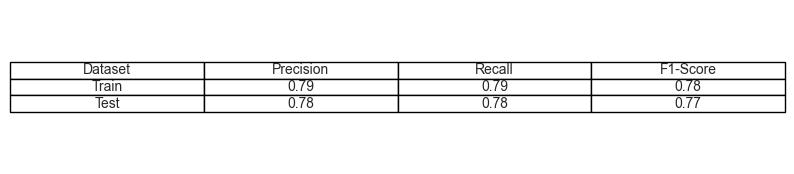

In [21]:
# Plot the DataFrame as a table
fig, ax = plt.subplots(figsize=(10, 2))  # Set the size of the figure
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=round(metrics_df,2).values, colLabels=round(metrics_df,2).columns, cellLoc='center', loc='center')

# Save the table as an image
plt.savefig('viz_outputs/metrics_df_point_ending.png', bbox_inches='tight', dpi=300)
plt.show()

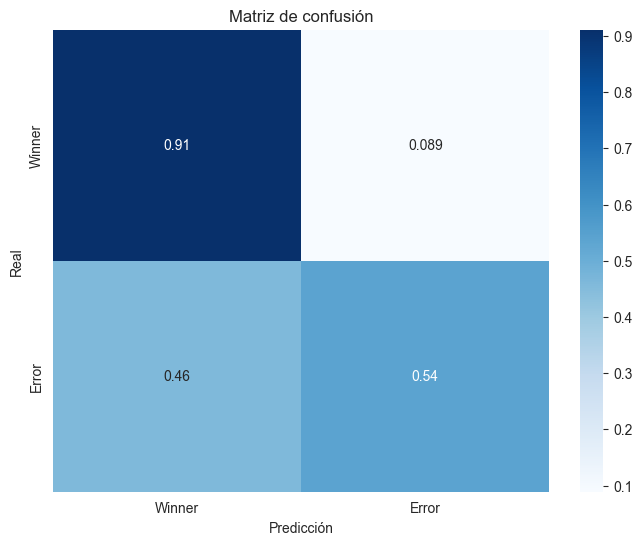

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a confusion matrix in pct
conf_matrix = confusion_matrix(y_type_test, y_test_pred)
conf_matrix_pct = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix, just two categories, winner and error
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pct, annot=True, cmap='Blues', xticklabels=['Winner', 'Error'], yticklabels=['Winner', 'Error'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')

# Save the figure
plt.savefig('viz_outputs/confusion_matrix_point_ending.png', bbox_inches='tight', dpi=300)
plt.show()


2230/2230 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


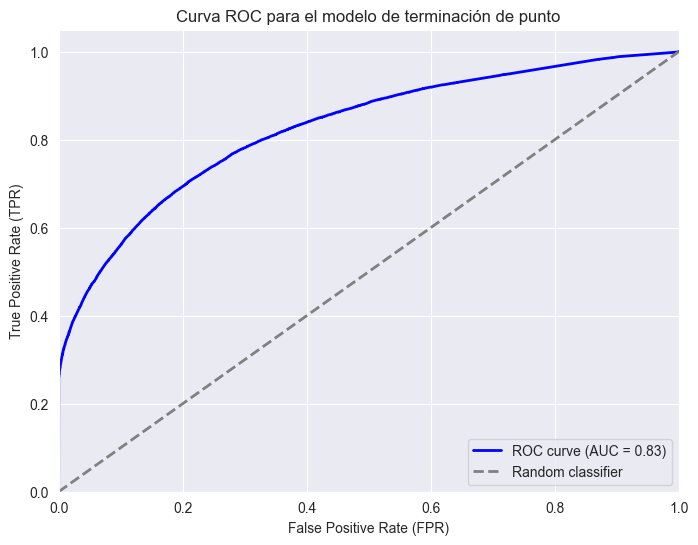

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que y_type_test contiene las clases verdaderas (0 para "errores", 1 para "winners")
# y que model.predict devuelve las probabilidades para cada clase

# Predecir las probabilidades de la clase positiva ("winners")
y_prob = model.predict([X_seq_test, context_features_test])[:, 1]  # Probabilidad de "winners"

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_type_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random classifier')  # Clasificador aleatorio
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC para el modelo de terminación de punto')
plt.legend(loc='lower right')

# Guardar la figura
plt.savefig('viz_outputs/roc_curve_point_ending.png', bbox_inches='tight', dpi=300)
plt.show()
